# Imports

In [2]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cpu')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/bodo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bodo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bodo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bodo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/bodo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 3. Denoising Autoencoder

## 3.1 Loading Data

In [3]:
ds = AG_NEWS_preparation(aug_params={})

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


Preparing sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [04:33<00:00, 438.51it/s]


Making sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [01:03<00:00, 1889.38it/s]


Embedding sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [01:07<00:00, 1771.03it/s]


Splitting sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:10<00:00, 11936.77it/s]

Done!


In [4]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])

In [5]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True, drop_last=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True, drop_last=True)

## 3.2 Training loop

In [17]:
m = Autoencoder(100,100,100,4,1,variational=False, max_log2len=8)
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [22]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [23]:
m = m.train()
EPOCHS = 6
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    m = m.train()
    pbar = tqdm(dl_train)
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx = m(x_in)
        L = (mx - x_out).pow(2).sum((1,2)).mean()
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()}")
        Ls_train.append(L.item())
    
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

Epoch: 0


VL: 216.19924926757812: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 26.41it/s]


Epoch: 1


VL: 205.18240356445312: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 23.80it/s]


Epoch: 2


VL: 203.92620849609375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 24.51it/s]


Epoch: 3


VL: 200.65829467773438: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 28.70it/s]


Epoch: 4


VL: 225.950439453125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 26.92it/s]


Epoch: 5


VL: 209.21376037597656: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 27.13it/s]


In [28]:
torch.save(({'train': Ls_train, 'valid':Ls_valid}, m.state_dict()), 'dae_small_9_AG.pt')

In [25]:
losses, _ = torch.load('dae_small_9_AG.pt')

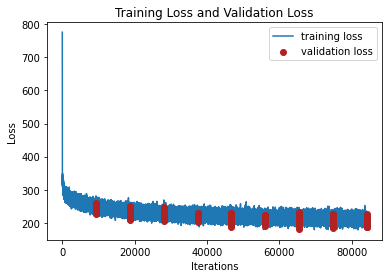

In [27]:
plt.plot(losses['train'], label='training loss')
for i in range(9):
    plt.scatter(
        [(i+1)*9349 for _ in range(31)],
        losses['valid'][i*31:(i+1)*31],
        zorder=2,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

As in the IMDB example, the training and validation losses closely match each other. The training loss lowers slightly. The final loss is higher than for the vanilla autoencoder, as expected.